# Apple Stock : An Exploratory and a Comparative Study

This notebook presents an exploratory analysis of a time series dataset i.e. Apple stock data. The dataset employed in this work was the daily stock price data in the year 2012-2018 (7 years).

The first part of this work is an exploratory analysis of the dataset, investigating the trend, stationarity and seasonality as well as autocorrelationof the data series.

The second part is the forecasting models development. We build two forecasting models i.e. the first model is built using the Holts and Winter model and the second one using the LSTM network. We adopted a  multisteps forecasting approach for the LSTM network.


In [1]:
#Loading the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

-  The data in the 'AAPL.csv' file contains daily stock price from 2012 and January 31st 2019.
-  We will train the stock open price data from (2012-2018) only and forecast the stock price for January 2019.


In [2]:
data=pd.read_csv('AAPL.csv',index_col = 'Date',parse_dates=True)
train=data.loc['2012-01-01':'2018-12-31']

In [3]:
train.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,58.485714,58.928570,58.428570,58.747143,39.340778,75555200
2012-01-04,58.571430,59.240002,58.468571,59.062859,39.552204,65005500
2012-01-05,59.278572,59.792858,58.952858,59.718571,39.991306,67817400
2012-01-06,59.967144,60.392857,59.888573,60.342857,40.409378,79573200
2012-01-09,60.785713,61.107143,60.192856,60.247143,40.345268,98506100


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1760 entries, 2012-01-03 to 2018-12-31
Data columns (total 6 columns):
Open         1760 non-null float64
High         1760 non-null float64
Low          1760 non-null float64
Close        1760 non-null float64
Adj Close    1760 non-null float64
Volume       1760 non-null int64
dtypes: float64(5), int64(1)
memory usage: 96.2 KB


-  The data has 6 columns. 
-  It has 1780 rows, which are the daily Apple stocks info since January 3rd 2012. 
-  For this work, we will be using the data in the second column i.e. Open to forecast the next 20 workdays 
   opening stock prices.
-  Let's explore the dataset first to get more insights.

In [5]:
train.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1.760000e+03
mean,115.177148,116.180330,114.119869,115.164644,105.975899,6.397904e+07
std,41.009036,41.356608,40.671363,41.021857,46.735278,4.825955e+07
min,55.424286,57.085712,55.014286,55.790001,39.340778,1.147590e+07
25%,82.072143,82.635713,81.412503,81.828928,63.219723,3.077658e+07
50%,107.890000,108.885002,106.820000,107.939999,102.281525,4.842095e+07
75%,141.670006,142.455002,140.904995,141.672505,137.963573,8.102082e+07
max,230.779999,233.470001,229.779999,232.070007,231.263092,3.765300e+08


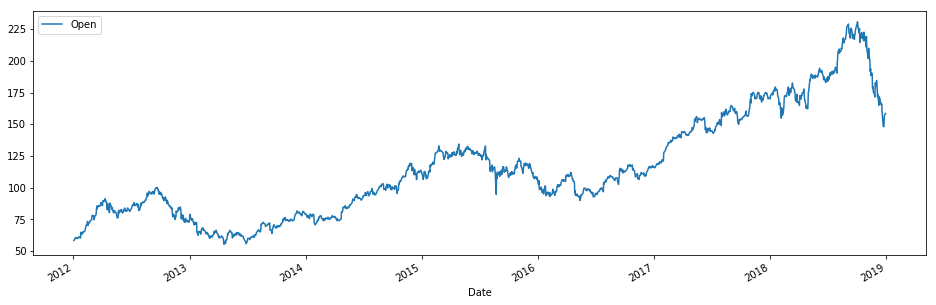

In [6]:
# Using the stock open price as the training data and plot the data of 7 years

train=train[['Open']]
train.plot(x=train.index,figsize=(16,5))

In [7]:
# Loading libraris for time-series analysis

from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

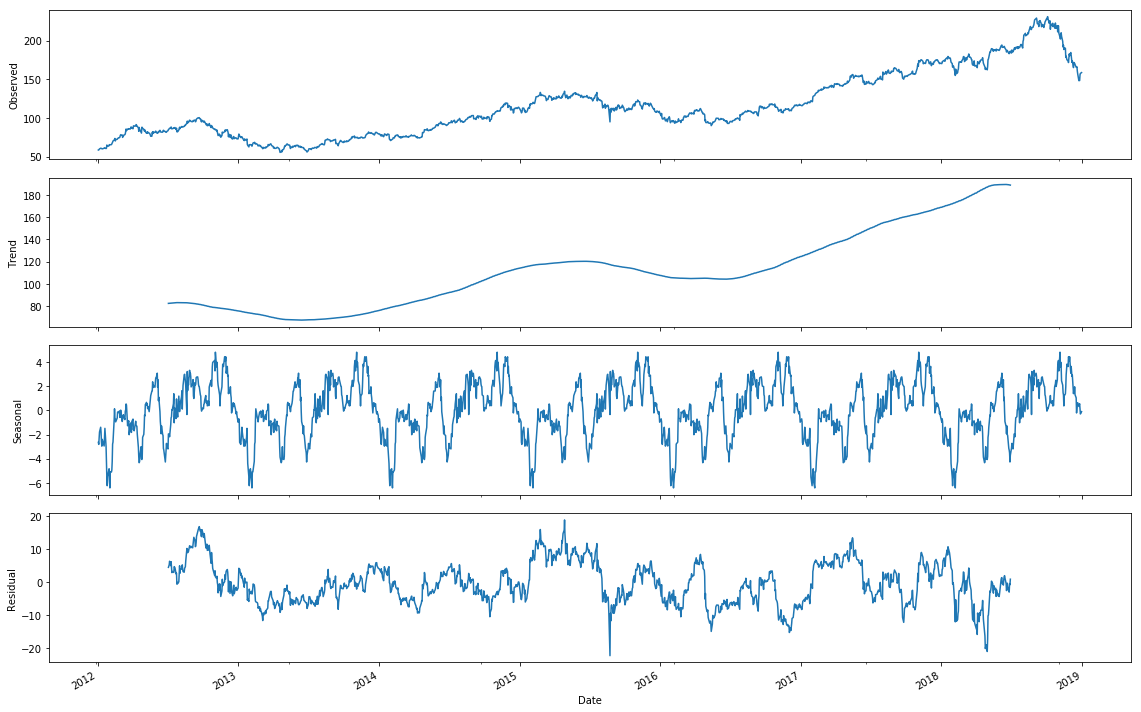

In [8]:
# Decomposing the train data into trend, seasonal and residual

rcParams['figure.figsize'] = 16, 10
train_season = seasonal_decompose(train, model = 'additive',freq=252)
season=train_season.plot()

- The decomposition of signals/data into trend, seasonal and residual helps to understand more about the behaviour of the data.
-  The trend plot shows that there is and upward trend although not 100% linear trend but we can deduce that it's increasing.
-  The seasonal plot is rather interesting, i would conclude that there is some seasonality in the data although not ver clear, but we could see that the seasonal patter repeats itself year after year.
- Next, we will run a stationarity test using the Adfuller method.

In [9]:
#Stationarity test using Adfuller method, the result is a non-stationary data

adfuller(train['Open'],autolag='AIC')[1]

0.55799363377870159

-  The stationarity test confirms that the data is non-stationary and from the previous graph we can also conclude that it is also seasonal.
-  Next, we will look at the ACF and PACF graph of the data.

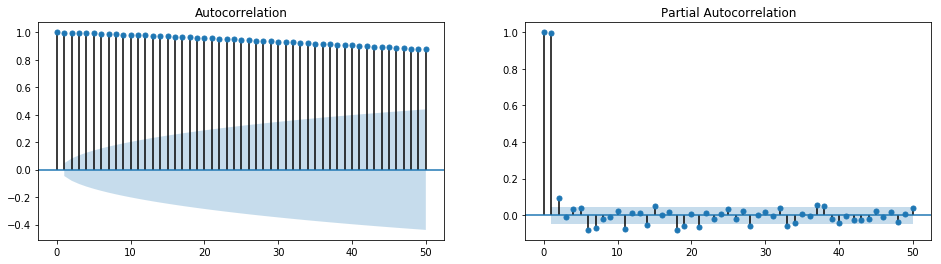

In [10]:
# The ACF and PACF plots

plt.figure(figsize = (16, 4))
plt.subplot(121); 
acf=plot_acf(train['Open'], lags = 50, ax = plt.gca())
plt.subplot(122); 
pacf=plot_pacf(train['Open'], lags =50, ax = plt.gca())


-  The ACF plot shows strong correlation for all the lags.
-  Nevertheless, the PACF plot shows a strong lag at lag 1 which suggest that the strong autocorrelation for lags 2 and above is  due to the propagation of autocorrelation at lags 1.
-  This also suggest that the data shows more autoregressive signature.
-  Next, we will model the data using the Holt-Winters model.
-  Although the data can also be model using the seasonal ARIMA model, due to the nature of the data that has daily data point of 252 points per year, this lead to complexity in the computation because of the high frequency.

### Holts-Winter model

In [11]:
model=ExponentialSmoothing(train, seasonal_periods=252, trend='add', seasonal='add')
model_fit = model.fit()

C:\Users\fatah\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [12]:
df_forecast_act=pd.DataFrame(data[['Open']].iloc[1760:1780])
df_forecast_act.rename(columns={'Open':'Actual'},inplace=True)
df_forecast_act['Forecast_HoltWinters']=model_fit.forecast(20).values
df_forecast_act

C:\Users\fatah\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


,Actual,Forecast_HoltWinters
Date,,
2019-01-02,154.889999,156.511051
2019-01-03,143.979996,155.165932
2019-01-04,144.529999,156.001883
2019-01-07,148.699997,157.239199
2019-01-08,149.559998,152.142152
2019-01-09,151.289993,146.013504
2019-01-10,152.500000,141.607105
2019-01-11,152.880005,139.027339
2019-01-14,150.850006,138.190644


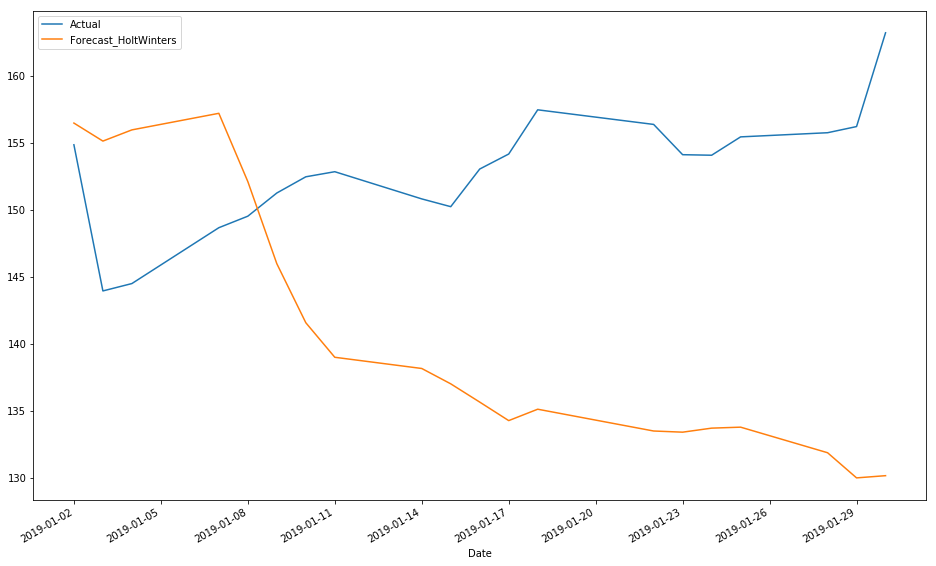

In [13]:
df_forecast_act.plot()

-  The plot in red shows the original data points in January 2019, the plot in blue is the predicted values for January 2019.
-  The forecasted values i.e. the January predicted prices, shows the opposite trend from the actual price although the fitted value from the last 7 years shows reasonably good predicted values.
-  Next, we will develop an LSTM network using Keras libraries and make similar predictions.


### LSTM Model

For this deep learning mode, we will use the Keras library with Tensoflow backend. We will create a network that produce multisteps output i.e. 20 steps output for every using 60 previous data points (lags 1-60).

We will first pre-process the input for network. The input tensor will be a 3D tensor of size (1680 x 60 x 1). We will only be using only one LSTM layer and one feedforward layer.

In [14]:
lstm_input=data[['Open']].iloc[:1760].values

In [15]:
# To train data using neural network, the data needs to rescaled between (0,1) values. 

scaler = MinMaxScaler(feature_range = (0, 1))
lstm_scaled = scaler.fit_transform(lstm_input)

In [16]:
# For every next 20 days forecast, we will be using the previous 60 days stock price, thus the following is to prepare the training input

X_train = []
y_train = []
for i in range(60, 1740):
    X_train.append(lstm_scaled[i-60:i, 0])
    y_train.append(lstm_scaled[i:i+20, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [17]:
# Reshaping the array to be used for LSTM inputs

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [18]:
# Checking their size are good

print(X_train.shape,y_train.shape)

(1680, 60, 1) (1680, 20)


In [19]:
# Loading keras libraries to develop LSTM network

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten

Using TensorFlow backend.


In [20]:
regressor = Sequential()

In [21]:
#First layer and a dropout for regularization -include

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

In [22]:
# Output layer
regressor.add(Flatten())
regressor.add(Dense(units = 20))

In [23]:
# Compiling the LSTM using adam optimiser and mse loss function

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [24]:
# Fitting the LSTM to the training set using 32 batch size and 100 epochs

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1680/1680 [==============================] - 6s 4ms/step - loss: 0.0123
Epoch 2/100
1680/1680 [==============================] - 4s 2ms/step - loss: 0.0037
Epoch 3/100
1680/1680 [==============================] - 4s 2ms/step - loss: 0.0035
Epoch 4/100
1680/1680 [==============================] - 4s 2ms/step - loss: 0.0031
Epoch 5/100
1680/1680 [==============================] - 4s 2ms/step - loss: 0.0034
Epoch 6/100
1680/1680 [==============================] - 4s 3ms/step - loss: 0.0030
Epoch 7/100
1680/1680 [==============================] - 4s 2ms/step - loss: 0.0026
Epoch 8/100
1680/1680 [==============================] - 3s 2ms/step - loss: 0.0025
Epoch 9/100
1680/1680 [==============================] - 4s 2ms/step - loss: 0.0025
Epoch 10/100
1680/1680 [==============================] - 4s 2ms/step - loss: 0.0024
Epoch 11/100
1680/1680 [==============================] - 4s 2ms/step - loss: 0.0025
Epoch 12/100
1680/1680 [==============================] - 4s 2ms/step - lo

1680/1680 [==============================] - 4s 2ms/step - loss: 0.0013
Epoch 98/100
1680/1680 [==============================] - 4s 2ms/step - loss: 0.0012
Epoch 99/100
1680/1680 [==============================] - 4s 2ms/step - loss: 0.0013
Epoch 100/100
1680/1680 [==============================] - ETA: 0s - loss: 0.001 - 4s 2ms/step - loss: 0.0012


-  Next we want to predict the next 20 days stock price i.e. January 2019, using the LSTM model that has been trained.
-  We will then plot the predicted graph together with the original data points on the same graph for visual inspection.




In [25]:
# Preparing the input data for the model to forecast the test data.
# We want to forecast the next 20 days after December 31st 2018, so we need to use/concantenate at least 60 days daata points prior December 31st.

inputs=data[['Open']].iloc[1700:1760].values
inputs=inputs.reshape(-1,1)
inputs=scaler.transform(inputs)
X_test=inputs
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[1], X_test.shape[0], 1))

In [26]:
# Predict the test data and also the train data using the tuned model

predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

In [27]:
# Putting together the forecasted data in the dataframe that we used in the previous model

df_forecast_act['Forecast_LSTM']=predicted_stock_price.reshape(20,1)

In [28]:
# The forecast prices using both methods

df_forecast_act

,Actual,Forecast_HoltWinters,Forecast_LSTM
Date,,,
2019-01-02,154.889999,156.511051,156.742920
2019-01-03,143.979996,155.165932,159.169128
2019-01-04,144.529999,156.001883,160.740601
2019-01-07,148.699997,157.239199,164.038193
2019-01-08,149.559998,152.142152,164.590469
2019-01-09,151.289993,146.013504,165.918167
2019-01-10,152.500000,141.607105,166.657089
2019-01-11,152.880005,139.027339,166.553284
2019-01-14,150.850006,138.190644,166.491516


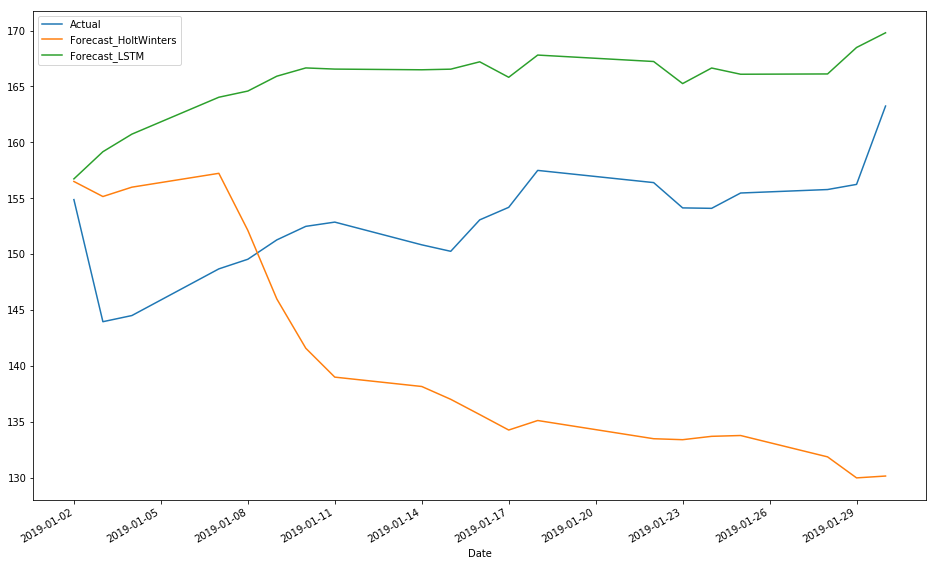

In [30]:
# Plot of the forecast vaue for the month of January 2019

df_forecast_act.plot()

-  From the plot, it can be seen that the forecasted prices using the LSTM network produced similar trend with the actual prices.
-  This is not bad cosidering stock forecasting is a difficult task and the main thing that we want to see here is that the model can produce similar trend.
-  Future work is to fine tune the network to minimise the gap.